In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.linalg.special_matrices import toeplitz
from numpy.random import multivariate_normal, randn

## **Definition**

***First part function definition***

In [2]:
def f(w):
    w1 = w[0]
    w2 = w[1]
    w3 = w[2]
    return (w1 + w2 + w3 - 5) ** 2 + 3 * (w1 - w2) ** 2 + 2 * (w2 - 2 * w3) ** 2


def f_gradient(w):
    w1 = w[0]
    w2 = w[1]
    w3 = w[2]
    return np.array(
        [
            8 * w1 - 4 * w2 + 2 * w3 - 10,
            -4 * w1 + 12 * w2 - 6 * w3 - 10,
            2 * w1 - 6 * w2 + 18 * w3 - 10,
        ]
    )


def f_hessian(w):
    w1 = w[0]
    w2 = w[1]
    w3 = w[2]
    return np.array(
        [np.array([8, -4, 2]), np.array([-4, 12, -6]), np.array([2, -6, 18])]
    )

***Rosenbrock function definition***

In [3]:
def f_rosenbrock(w):
    w1 = w[0]
    w2 = w[1]
    return 100 * (w2 - w1**2) ** 2 + (1 - w1) ** 2


def f_rosenbrock_gradient(w):
    w1 = w[0]
    w2 = w[1]
    return np.array(
        [2 * (200 * w1**3 - 200 * w1 * w2 + w1 - 1), 200 * (w2 - w1**2)]
    )


def f_rosenbrock_hessian(w):
    w1 = w[0]
    w2 = w[1]
    return np.array(
        [
            np.array([1200 * w1**2 - 400 * w2 + 2, -400 * w1]),
            np.array([-400 * w1, 200]),
        ]
    )

***Third part function definition (Machine learning)***

In [4]:
def f_i(xi, yi, w, lbda):
    return np.log(1 + np.exp(-yi * xi.T.dot(w))) + (lbda / 2) * w.dot(w.T)


def f_gradient_i(xi, yi, w, lbda):
    aux = 1 + np.exp(yi * xi.T.dot(w))
    return -(yi / aux) * xi + lbda * w


def f_hessian_i(xi, yi, w, lbda):
    d = xi.shape[0]
    yxw = yi * w.T.dot(xi)
    xi_dot_xi = np.array([xi]).T.dot(np.array([xi]))
    return (np.exp(yxw) / (1 + np.exp(yxw)) ** 2) * xi_dot_xi + lbda * np.identity(d)

***Sampling function***

In [5]:
def simu_linmodel(w, n, std=1.0, corr=0.5):
    """
    Simulation values obtained by a linear model with additive noise
    Source: https://www.lamsade.dauphine.fr/~croyer/ensdocs/ODD/SourcesLabODD03.zip

    Parameters
    ----------
    w : np.ndarray, shape=(d,)
        The coefficients of the model

    n : int
        Sample size

    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the feature matrix
    """
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

## **Newton's method**

***Model***

In [6]:
class NewtonMethod:
    def __init__(self, f, f_gradient, f_hessian):
        self.f = f
        self.f_gradient = f_gradient
        self.f_hessian = f_hessian

    @staticmethod
    def is_inversible(matrix):
        return np.linalg.det(matrix) != 0

    @staticmethod
    def get_gamma_k(mu, f_hessian_wk):
        lambda_min = np.nanmin(np.linalg.eigvalsh(f_hessian_wk)).item()
        return mu * np.nanmax(np.append(lambda_min, 10 ^ -10)).item()

    @staticmethod
    def dk_formula(f_grad_w, f_hess_w):
        return -np.linalg.inv(f_hess_w).dot(f_grad_w)

    def solve(self, max_iter, eps, w0):
        wk = w0
        iter = 0
        solved = False
        while iter < max_iter:
            f_gradient_wk = self.f_gradient(wk)
            f_hessian_wk = self.f_hessian(wk)
            if self.is_inversible(f_hessian_wk):
                dk = -np.linalg.inv(f_hessian_wk).dot(f_gradient_wk)
                wk = wk + dk
                iter += 1
                if dk.T.dot(dk) < eps:  # convergence condition test
                    solved = True
                    break
            else:
                wk = None
                break
        return {"w": wk, "iteration": iter, "solved": solved}

    def solve_with_regularization(self, max_iter, eps, c, mu, w0):
        d = w0.shape[0]
        wk = w0
        iter = 0
        solved = False
        while iter < max_iter:
            f_gradient_wk = self.f_gradient(wk)
            f_hessian_wk = self.f_hessian(wk)
            gamma_k = self.get_gamma_k(mu, f_hessian_wk)
            aux = f_hessian_wk + gamma_k * np.identity(d)
            if self.is_inversible(aux):
                dk = self.dk_formula(f_gradient_wk, aux)
                while self.f(wk + dk) >= self.f(wk) + c * dk.T.dot(f_gradient_wk):
                    gamma_k = mu * gamma_k
                    aux = f_hessian_wk + gamma_k * np.identity(d)
                    if self.is_inversible(aux):
                        dk = self.dk_formula(f_gradient_wk, aux)
                    else:
                        # not inversible
                        return {"w": None, "iteration": iter, "solved": solved}
                wk = wk + dk
                if dk.T.dot(dk) < eps:  # convergence condition test
                    solved = True
                    break
                iter += 1
            else:
                # not inversible
                wk = None
                break
        return {"w": wk, "iteration": iter, "solved": solved}

In [7]:
minimizer = NewtonMethod(f, f_gradient, f_hessian)
print("Starting point {}:".format(np.ones(3)))
print(minimizer.solve(1, 10**-3, np.ones(3))["w"], end="\n\n")
print("Starting point {}:".format(np.zeros(3)))
print(minimizer.solve(1, 10**-3, np.zeros(3))["w"], end="\n\n")
print("Starting point (random):")
print(minimizer.solve(1, 10**-3, np.random.randn(3))["w"], end="\n\n")
print("q(w*) = {}".format(minimizer.f(np.array([2, 2, 1]))))

Starting point [1. 1. 1.]:
[2. 2. 1.]

Starting point [0. 0. 0.]:
[2. 2. 1.]

Starting point (random):
[2. 2. 1.]

q(w*) = 0


In [8]:
minimizer = NewtonMethod(f_rosenbrock, f_rosenbrock_gradient, f_rosenbrock_hessian)

P1 = np.array([-1.2, 1])
P2 = np.array([0, 1 / 400 + 10**-12])
P3 = np.array([0, 0.005])

print("Starting point {}:".format(P1))
print(minimizer.solve(100, 10**-3, P1), end="\n\n")

print("Starting point {}:".format(P2))
print(minimizer.solve(100, 10**-3, P2), end="\n\n")

print(
    "DET(f_rosenbrock_hessian(P3)) = {}".format(
        np.linalg.det(f_rosenbrock_hessian(P3))
    ),
    end="\n\n",
)

print("f_rosenbrock(w*) = {}".format(f_rosenbrock(np.array([1, 1]))))

Starting point [-1.2  1. ]:
{'w': array([1., 1.]), 'iteration': 6, 'solved': True}

Starting point [0.     0.0025]:
{'w': array([1.       , 0.9999999]), 'iteration': 5, 'solved': True}

DET(f_rosenbrock_hessian(P3)) = 0.0

f_rosenbrock(w*) = 0


**Globally convergent version of Newton's method**

In [9]:
print("Starting point {} (with regularization):".format(P1))
print(minimizer.solve_with_regularization(30, 10**-3, 0.0001, 2, P1), end="\n\n")
print("Starting point {} (with regularization):".format(P2))
print(minimizer.solve_with_regularization(30, 10**-3, 0.0001, 2, P2))

Starting point [-1.2  1. ] (with regularization):
{'w': array([0.96971296, 0.94005116]), 'iteration': 25, 'solved': True}

Starting point [0.     0.0025] (with regularization):
{'w': array([0.970239  , 0.94107877]), 'iteration': 16, 'solved': True}


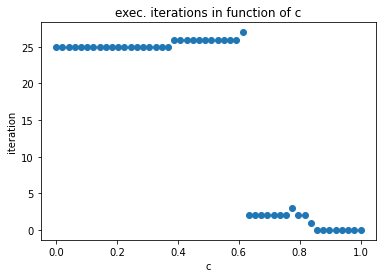

/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
  del sys.path[0]


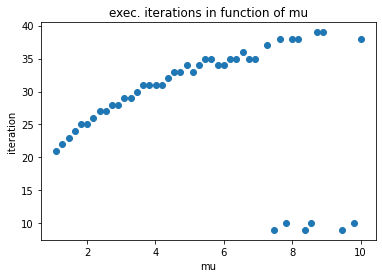

In [10]:
c_list = np.linspace(0.0001, 1, 50)
mu_list = np.linspace(1.1, 10, 50)

iteration_list = []
c_plot = []
for c in c_list:
    try:
        res = minimizer.solve_with_regularization(1000, 10**-3, c, 2, P1)
        if res["solved"] == True:
            iteration_list.append(res["iteration"])
            c_plot.append(c)
    except np.linalg.LinAlgError:
        continue

plt.figure()
plt.scatter(c_plot, iteration_list)
plt.title("exec. iterations in function of c")
plt.xlabel("c")
plt.ylabel("iteration")
plt.show()

iteration_list = []
mu_plot = []
for mu in mu_list:
    try:
        res = minimizer.solve_with_regularization(1000, 10**-3, 0.0001, mu, P1)
        if res["solved"] == True:
            iteration_list.append(res["iteration"])
            mu_plot.append(mu)
    except np.linalg.LinAlgError:
        continue

plt.figure()
plt.scatter(mu_plot, iteration_list)
plt.title("exec. iterations in function of mu")
plt.xlabel("mu")
plt.ylabel("iteration")
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
  del sys.path[0]


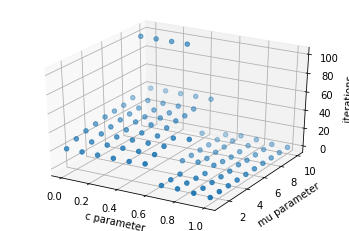

In [11]:
flat_c = []
flat_mu = []
flat_iter = []
for c in np.linspace(0.0001, 1, 10):
    for mu in np.linspace(1.1, 10, 10):
        try:
            flat_iter.append(
                minimizer.solve_with_regularization(100, 10**-3, c, mu, P1)[
                    "iteration"
                ]
            )
            flat_c.append(c)
            flat_mu.append(mu)
        except np.linalg.LinAlgError as err:
            continue

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter3D(flat_c, flat_mu, flat_iter)
ax.set_xlabel("c parameter")
ax.set_ylabel("mu parameter")
ax.set_zlabel("iterations")
plt.show()

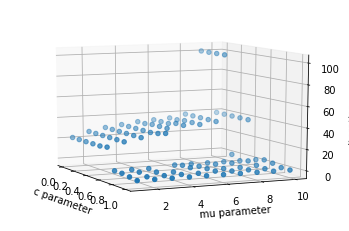

In [12]:
ax.view_init(10, -25)
fig

/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
  del sys.path[0]


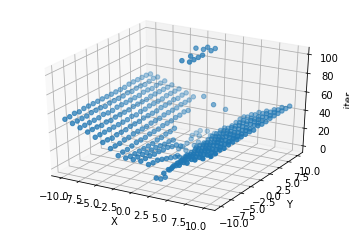

In [13]:
flat_x = []
flat_y = []
flat_iter = []
c = 0.5
mu = 1.5
for x in np.linspace(-10, 10, 20):
    for y in np.linspace(-10, 10, 20):
        try:
            P = np.array([x, y])
            flat_iter.append(
                minimizer.solve_with_regularization(100, 10**-3, c, mu, P)[
                    "iteration"
                ]
            )
            flat_x.append(x)
            flat_y.append(y)
        except np.linalg.LinAlgError as err:
            continue

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter3D(flat_x, flat_y, flat_iter)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("iter.")
plt.show()

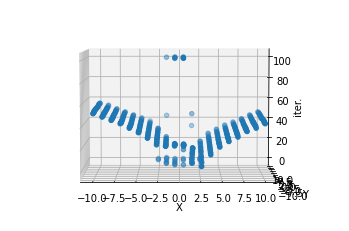

In [14]:
ax.view_init(5, -90)
fig

## **Subsampling Newton-type methods**

***Sampling***

In [15]:
SEED = 0

d = 4
n = 500
idx = np.arange(d)
lbda = 1.0 / n ** (0.5)
w_model_truth = (-1) ** idx * np.exp(-idx / 10.0)

np.random.seed(SEED)

Xlog, ylog = simu_linmodel(w_model_truth, n, std=1.0, corr=0.7)
ylog = np.sign(ylog)

In [16]:
w_model_truth

array([ 1.        , -0.90483742,  0.81873075, -0.74081822])

***Model***

In [17]:
class SubSamplingNewton:
    def __init__(self, f_i, f_gradient_i, f_hessian_i, X, y, lbda):
        self.f_i = f_i
        self.f_gradient_i = f_gradient_i
        self.f_hessian_i = f_hessian_i
        self.n, self.d = X.shape
        self.X = X
        self.y = y
        self.lbda = lbda
        self.generator = np.random.default_rng()
        self.S_full = np.linspace(0, self.n - 1, self.n).astype(int)

    # batch methods
    def batch_f(self, S, w):
        aux = 0
        for s in S:
            aux += self.f_i(self.X[s], self.y[s], w, self.lbda)
        return (1 / len(S)) * aux

    def batch_f_gradient(self, S, w):
        aux = np.zeros(self.d)
        for s in S:
            aux += self.f_gradient_i(self.X[s], self.y[s], w, self.lbda)
        return (1 / len(S)) * aux

    def batch_f_hessian(self, S, w):
        aux = np.zeros([self.d, self.d])
        for s in S:
            aux += self.f_hessian_i(self.X[s], self.y[s], w, self.lbda)
        return (1 / len(S)) * aux

    # regular methods
    def f(self, w):
        return self.batch_f(self.S_full, w)

    def f_gradient(self, w):
        return self.batch_f_gradient(self.S_full, w)

    def f_hessian(self, w):
        return self.batch_f_hessian(self.S_full, w)

    def get_epoch(self, iteration, batch_size_grad, batch_size_hess):
        return iteration * (batch_size_grad + batch_size_hess) / (2 * self.n)

    # solving methods
    @staticmethod
    def get_gamma_k(mu, f_hessian_wk):
        lambda_min = np.nanmin(np.linalg.eigvalsh(f_hessian_wk)).item()
        return mu * np.nanmax(np.append(-lambda_min, 10 ^ -10)).item()

    @staticmethod
    def dk_formula(f_grad_w, f_hess_w):
        return -np.linalg.inv(f_hess_w).dot(f_grad_w)

    @staticmethod
    def is_inversible(matrix):
        return np.linalg.det(matrix) != 0

    def solve_sub_sampling(
        self, max_iter, eps, c, mu, batch_size_grad, batch_size_hess, w0
    ):
        wk = w0
        i = 0
        flag = False
        while i < max_iter:
            Sk = self.generator.choice(self.S_full, batch_size_grad, replace=False)
            Sk_h = self.generator.choice(self.S_full, batch_size_hess, replace=False)
            f_gradient_wk = self.batch_f_gradient(Sk, wk)
            f_hessian_wk = self.batch_f_hessian(Sk_h, wk)
            gamma_k = self.get_gamma_k(mu, f_hessian_wk)
            aux = f_hessian_wk - gamma_k * np.identity(self.d)
            if self.is_inversible(aux):
                dk = self.dk_formula(f_gradient_wk, aux)
                while self.batch_f(Sk, wk + dk) >= self.batch_f(Sk, wk) + c * dk.T.dot(
                    f_gradient_wk
                ):
                    gamma_k = mu * gamma_k
                    aux = f_hessian_wk - gamma_k * np.identity(self.d)
                    if self.is_inversible(aux):
                        dk = self.dk_formula(f_gradient_wk, aux)
                    else:
                        return {
                            "w": None,
                            "epoch": self.get_epoch(
                                i, batch_size_grad, batch_size_hess
                            ),
                            "solved": False,
                        }
                wk = wk + dk
                if dk.T.dot(dk) < eps:
                    flag = True
                    break
                i += 1
            else:
                wk = None
                break
        return {
            "w": wk,
            "epoch": self.get_epoch(i, batch_size_grad, batch_size_hess),
            "solved": flag,
        }

    def solve_regularized(self, max_iter, eps, c, mu, w0):
        res = self.solve_sub_sampling(max_iter, eps, c, mu, self.n, self.n, w0)
        return res

    def get_n(self):
        return self.X.shape[0]

    def get_d(self):
        return self.X.shape[1]

    def lipschitz_grad(self):
        L = (4 / self.get_n()) * norm(self.X, 2) ** 2 + self.lbda
        return L

In [18]:
np.random.seed(SEED)

minimizer = SubSamplingNewton(f_i, f_gradient_i, f_hessian_i, Xlog, ylog, lbda)

In [19]:
np.random.seed(SEED)

P = np.random.randn(d)
print("Starting point {} (with subsampling Newton):".format(P))
res = minimizer.solve_sub_sampling(300, 10**-3, 0.0001, 2, 200, 50, P)
print(res, end="\n\n")

print("Model solution :")
print(w_model_truth, end="\n\n")

print("f(w*) =", minimizer.batch_f(minimizer.S_full, w_model_truth))
print("f(w_batch) =", minimizer.batch_f(minimizer.S_full, res["w"]))

Starting point [1.76405235 0.40015721 0.97873798 2.2408932 ] (with subsampling Newton):
{'w': array([ 0.82956002, -0.38256734,  0.6358779 , -0.69486785]), 'epoch': 6.5, 'solved': True}

Model solution :
[ 1.         -0.90483742  0.81873075 -0.74081822]

f(w*) = 0.6063718322498088
f(w_batch) = 0.5901178895515109


In [20]:
np.random.seed(SEED)

print("Starting point {} (with regularized Newton):".format(P))
res_reg = minimizer.solve_regularized(1000, 10**-3, 0.0001, 2, P)
print(res_reg, end="\n\n")

print("Model solution :")
print(w_model_truth, end="\n\n")

print("f(w*) =", minimizer.batch_f(minimizer.S_full, w_model_truth))
print("f(w_batch) =", minimizer.batch_f(minimizer.S_full, res_reg["w"]))

Starting point [1.76405235 0.40015721 0.97873798 2.2408932 ] (with regularized Newton):
{'w': array([ 0.84873374, -0.41264048,  0.54895286, -0.64057408]), 'epoch': 7.0, 'solved': True}

Model solution :
[ 1.         -0.90483742  0.81873075 -0.74081822]

f(w*) = 0.6063718322498088
f(w_batch) = 0.5896426750722292


In [21]:
np.random.seed(SEED)

MAX_ITER = 1000
EPS = 10**-2
C = 0.0001
MU = 2

flat_gradient_batch_size = []
flat_hessian_batch_size = []
flat_epoch = []

print("[SUB SAMPLING]")
sizes = np.array(
    [
        1,
        n * 0.02,
        n * 0.1,
        n * 0.2,
        n * 0.3,
        n * 0.4,
        n * 0.5,
        n * 0.6,
        n * 0.7,
        n * 0.8,
        n * 0.9,
    ]
).astype(int)
for b_size in sizes:
    for b_size_H in sizes:
        res = minimizer.solve_sub_sampling(
            max_iter=MAX_ITER,
            eps=EPS,
            c=C,
            mu=MU,
            batch_size_grad=b_size,
            batch_size_hess=b_size_H,
            w0=np.ones(d),
        )

        if res["solved"] and res["epoch"] < 80:
            flat_gradient_batch_size.append(b_size)
            flat_hessian_batch_size.append(b_size_H)
            flat_epoch.append(res["epoch"])

        print(
            "> |Sk|={:4d} and |Sk_h|={:4d}: f(w)= {:10.5f} (solved: {}) \t in {:8.2f} epoch(s)".format(
                b_size, b_size_H, minimizer.f(res["w"]), res["solved"], res["epoch"]
            )
        )

[SUB SAMPLING]
> |Sk|=   1 and |Sk_h|=   1: f(w)=    9.12430 (solved: False) 	 in     2.00 epoch(s)
> |Sk|=   1 and |Sk_h|=  10: f(w)=    2.18163 (solved: False) 	 in    11.00 epoch(s)
> |Sk|=   1 and |Sk_h|=  50: f(w)=    1.14071 (solved: False) 	 in    51.00 epoch(s)
> |Sk|=   1 and |Sk_h|= 100: f(w)=    1.66664 (solved: False) 	 in   101.00 epoch(s)
> |Sk|=   1 and |Sk_h|= 150: f(w)=    1.76116 (solved: False) 	 in   151.00 epoch(s)
> |Sk|=   1 and |Sk_h|= 200: f(w)=    1.28082 (solved: False) 	 in   201.00 epoch(s)
> |Sk|=   1 and |Sk_h|= 250: f(w)=    3.66412 (solved: False) 	 in   251.00 epoch(s)
> |Sk|=   1 and |Sk_h|= 300: f(w)=    3.94372 (solved: False) 	 in   301.00 epoch(s)
> |Sk|=   1 and |Sk_h|= 350: f(w)=    2.03817 (solved: False) 	 in   351.00 epoch(s)
> |Sk|=   1 and |Sk_h|= 400: f(w)=    1.71450 (solved: False) 	 in   401.00 epoch(s)
> |Sk|=   1 and |Sk_h|= 450: f(w)=    3.43072 (solved: False) 	 in   451.00 epoch(s)
> |Sk|=  10 and |Sk_h|=   1: f(w)=    0.93038 (sol

In [22]:
np.random.seed(SEED)

print("[REGULAR]")
res_reg = minimizer.solve_regularized(
    max_iter=MAX_ITER, eps=EPS, c=C, mu=MU, w0=np.ones(d)
)
print(
    "> f(w)= {:10.5f} (solved: {}) \t in {:8.2f} epoch(s)".format(
        minimizer.f(res_reg["w"]), res_reg["solved"], res_reg["epoch"]
    )
)

[REGULAR]
> f(w)=    0.59130 (solved: True) 	 in     3.00 epoch(s)


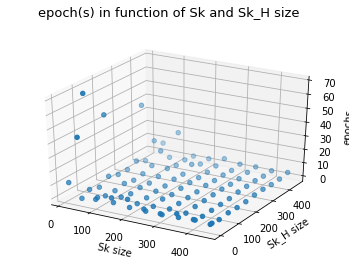

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
fig.suptitle("epoch(s) in function of Sk and Sk_H size", fontsize=13)
ax.scatter3D(flat_gradient_batch_size, flat_hessian_batch_size, flat_epoch)
ax.set_xlabel("Sk size")
ax.set_ylabel("Sk_H size")
ax.set_zlabel("epochs")
plt.show()

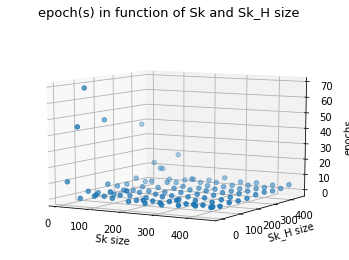

In [24]:
ax.view_init(10, -60)
fig

## **Stochastic gradient comparison**

In [25]:
# Stochastic gradient implementation
def stoch_grad(
    w0,
    problem,
    wtarget,
    stepchoice=0,
    step0=1,
    n_iter=1000,
    nb=1,
    with_replace=False,
    verbose=False,
):
    """
    A code for gradient descent with various step choices.
    Source: https://www.lamsade.dauphine.fr/~croyer/ensdocs/ODD/SourcesLabODD03.zip

    Inputs:
        w0: Initial vector
        problem: Problem structure
            problem.fun() returns the objective function, which is assumed to be a finite sum of functions
            problem.n returns the number of components in the finite sum
            problem.grad_i() returns the gradient of a single component f_i
            problem.lipgrad() returns the Lipschitz constant for the gradient
            problem.cvxval() returns the strong convexity constant
            problem.lambda returns the value of the regularization parameter
        wtarget: Target minimum (unknown in practice!)
        stepchoice: Strategy for computing the stepsize
            0: Constant step size equal to 1/L
            t>0: Step size decreasing in 1/(k+1)**t
        step0: Initial steplength (only used when stepchoice is not 0)
        n_iter: Number of iterations, used as stopping criterion
        nb: Number of components drawn per iteration/Batch size
            1: Classical stochastic gradient algorithm (default value)
        with_replace: Boolean indicating whether components are drawn with or without replacement
            True: Components drawn with replacement
            False: Components drawn without replacement (Default)
        verbose: Boolean indicating whether information should be plot at every iteration (Default: False)

    Outputs:
        w_output: Final iterate of the method (or average if average=1)
        objvals: History of function values (Numpy array of length n_iter at most)
        normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []

    # iterates distance to the minimum history
    normits = []

    # Lipschitz constant
    L = problem.lipschitz_grad()

    # Number of samples
    n = problem.get_n()

    # Initial value of current iterate
    w = w0.copy()
    nw = norm(w)

    # Initialize iteration counter
    k = 0

    # Current objective
    obj = problem.f(w)
    objvals.append(obj)
    # Current distance to the optimum
    nmin = norm(w - wtarget)
    normits.append(nmin)

    if verbose:
        # Plot initial quantities of interest
        print("Stochastic Gradient, batch size=", nb, "/", n)
        print(" | ".join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(
            " | ".join(
                [("%d" % k).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % nmin).rjust(8)]
            )
        )

    ################
    # Main loop
    while k < n_iter and nw < 10**100:
        # Draw the batch indices
        ik = np.random.choice(n, nb, replace=with_replace)  # Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            index = ik[j]
            gi = problem.f_gradient_i(
                problem.X[index], problem.y[index], w, problem.lbda
            )
            sg = sg + gi
        sg = (1 / nb) * sg

        if stepchoice == 0:
            w[:] = w - (step0 / L) * sg
        elif stepchoice > 0:
            sk = float(step0 / ((k + 1) ** stepchoice))
            w[:] = w - sk * sg

        nw = norm(w)  # Computing the norm to measure divergence

        obj = problem.f(w)
        nmin = norm(w - wtarget)

        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k * nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(
                    " | ".join(
                        [
                            ("%d" % k).rjust(8),
                            ("%.2e" % obj).rjust(8),
                            ("%.2e" % nmin).rjust(8),
                        ]
                    )
                )

    # End of main loop
    #################

    # Plot quantities of interest for the last iterate (if needed)
    if (k * nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(
                " | ".join(
                    [
                        ("%d" % k).rjust(8),
                        ("%.2e" % obj).rjust(8),
                        ("%.2e" % nmin).rjust(8),
                    ]
                )
            )

    # Outputs
    w_output = w.copy()

    return w_output, np.array(objvals), np.array(normits)

In [26]:
np.random.seed(SEED)

w_sg, obj_vals, normits = stoch_grad(
    w0=np.ones(minimizer.get_d()),
    problem=minimizer,
    wtarget=w_model_truth,
    stepchoice=0,
    step0=1,
    n_iter=MAX_ITER,
    nb=100,
    with_replace=True,
    verbose=True,
)

Stochastic Gradient, batch size= 100 / 500
  iter   |   fval   |  normit 
       0 | 1.34e+00 | 2.59e+00
       5 | 1.20e+00 | 2.37e+00
      10 | 1.07e+00 | 2.16e+00
      15 | 9.58e-01 | 1.98e+00
      20 | 8.58e-01 | 1.82e+00
      25 | 7.80e-01 | 1.67e+00
      30 | 7.32e-01 | 1.58e+00
      35 | 6.89e-01 | 1.49e+00
      40 | 6.61e-01 | 1.42e+00
      45 | 6.41e-01 | 1.36e+00
      50 | 6.28e-01 | 1.31e+00
      55 | 6.22e-01 | 1.27e+00
      60 | 6.17e-01 | 1.23e+00
      65 | 6.14e-01 | 1.21e+00
      70 | 6.10e-01 | 1.18e+00
      75 | 6.08e-01 | 1.15e+00
      80 | 6.06e-01 | 1.13e+00
      85 | 6.05e-01 | 1.10e+00
      90 | 6.03e-01 | 1.07e+00
      95 | 6.01e-01 | 1.04e+00
     100 | 6.01e-01 | 1.02e+00
     105 | 6.00e-01 | 1.01e+00
     110 | 5.99e-01 | 9.90e-01
     115 | 5.98e-01 | 9.68e-01
     120 | 5.97e-01 | 9.50e-01
     125 | 5.97e-01 | 9.34e-01
     130 | 5.96e-01 | 9.17e-01
     135 | 5.95e-01 | 9.00e-01
     140 | 5.95e-01 | 8.92e-01
     145 | 5.94e-01 | 8.76e

In [27]:
print(w_sg)
print(minimizer.f(w_sg))

[ 0.84160705 -0.42517643  0.57450168 -0.68238199]
0.589671167650645
